> the initial estimates:
mu = 254.01420454545453
sig = 2.4558192585954752
a = 0.45197856183503293
> the final fitted estimates:
mu = 254.23932469917565 ± 0.08702080342591956
sig = 2.2377525945577363 ± 0.08702081268409385
a = 0.4454704262602664 ± 0.015002435244369963
Peak counts 1: 0.07941762111498857
> the initial estimates:
mu = 663.6633663366337
sig = 5.282658398655603
a = 0.12968703052652933

> the final fitted estimates:
mu = 666.3220069722374 ± 0.3000644957151902
sig = 2.529385987006508 ± 0.30006450017908526
a = 0.10330252677827977 ± 0.010612995529133291
Peak counts 2: 0.016293181750773635
y = 8.20590 * x + 1.42750


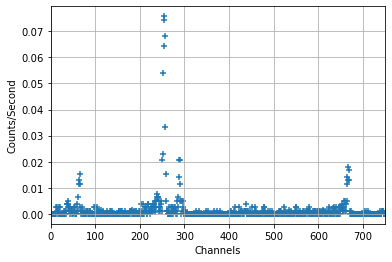

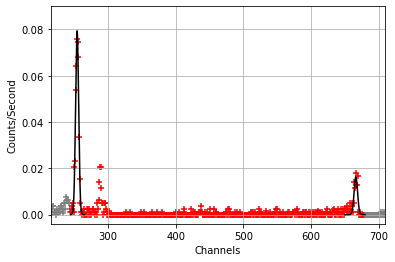

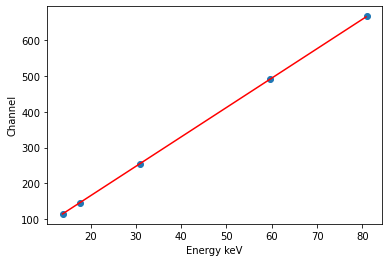

C:\Users\marti\AppData\Local\Temp\ipykernel_5600\892936193.py:313: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(R_2))


R2 = -11.55720 * E-2 + 1.58243 * E-1 + -0.01301


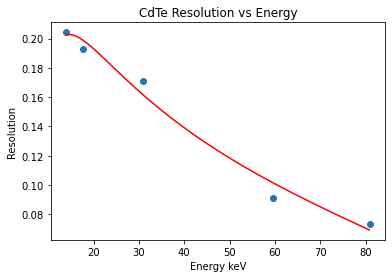

Ea = -0.00000 + 0.00000 * log(E) + -0.00000 * (log(E))^2


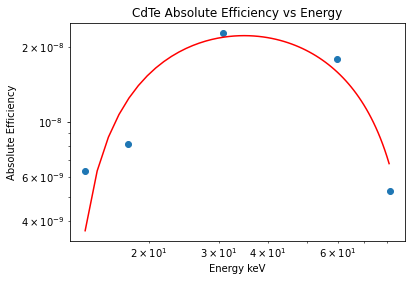

Ea = -0.00474 + 0.00291 * log(E) + -0.00041 * (log(E))^2


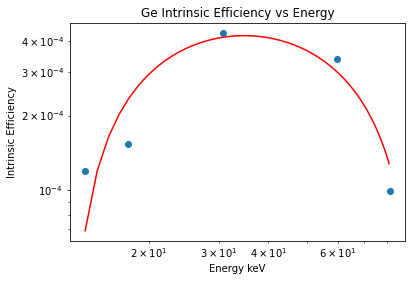

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from scipy.optimize import curve_fit
from numpy import inf as INF

# folder path
dir_path = r"C:\Users\Home\Desktop\Lab Data Master\CdTe Detector 0"

# to store file names
res = []

# construct path object
d = pathlib.Path(dir_path)

# iterate directory
for entry in d.iterdir():
    # check if it a file
    if entry.is_file():
        res.append(entry)
        
CHANNELS = np.array(list(range(2048)))
BACKGROUND = (np.genfromtxt(res[1],skip_header=12,skip_footer=73)/600)

def Isotope_Choice(x):
    if x == 0:
        COUNTS = (((np.genfromtxt(res[0],skip_header=12,skip_footer=73))/300) - BACKGROUND)
        Roi_Start = 110
        Roi_End = 155
        Roi_Start_2 = 400
        Roi_End_2 = 600
        Top = 0.4
    if x == 2: 
        COUNTS = abs(((np.genfromtxt(res[2],skip_header=12,skip_footer=73))/778.798000) - BACKGROUND)
        Roi_Start = 245
        Roi_End = 265
        Roi_Start_2 = 650
        Roi_End_2 = 680
        Top = 0.09

    return (COUNTS, Roi_Start, Roi_End, Roi_Start_2, Roi_End_2, Top)

#Am:res[0]
#Ba:res[2]


COUNTS,Roi_Start, Roi_End, Roi_Start_2, Roi_End_2, Top = Isotope_Choice(2)


def plot_spectrum(ax, channels, counts, 
                  xlabel='Channels', ylabel='Counts/Second', 
                  **kwargs):
    """Helper function to plot spectra."""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)

    return ax.scatter(channels, counts, **kwargs)


TWO_PI = np.pi * 2.

def gaussian(x, mu, sig, a):
    return a * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(TWO_PI * sig**2)

def double_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2)

def in_interval(x, xmin=-INF, xmax=INF):
    """Boolean mask with value True for x in [xmin, xmax) ."""
    _x = np.asarray(x)
    return np.logical_and(xmin <= _x, _x < xmax) 

def filter_in_interval(x, y, xmin, xmax):
    """Selects only elements of x and y where xmin <= x < xmax."""
    # TODO: check x.shape == y.shape?
    _mask = in_interval(x, xmin, xmax)
    return [np.asarray(x)[_mask] for x in (x, y)]

def colourmask(x, xmin=-INF, xmax=INF, cin='red', cout='gray'):
    """Colour cin if within region of interest, cout otherwise."""
    # compute mask as integers 0 or 1
    _mask = np.array(in_interval(x, xmin, xmax), dtype=int)

    # convert to colours
    colourmap = np.array([cout, cin])
    return colourmap[_mask]

def simple_model_fit(model, channels, counts, roi, **kwargs):
    """Least squares estimate of model parameters."""
    # select relevant channels & counts
    _channels, _counts = filter_in_interval(channels, counts, *roi)
    
    # fit the model to the data
    popt, pcov = curve_fit(model, _channels, _counts, **kwargs)
    return popt, pcov

def format_result(params, popt, pcov):
    """Display parameter best estimates and uncertainties."""
    # extract the uncertainties from the covariance matrix
    perr = np.sqrt(np.diag(pcov))
    
    # format parameters with best estimates and uncertainties
    # TODO: should probably round these to a sensible precision! 
    _lines = (f"{p} = {o} ± {e}" for p, o, e in zip(params, popt, perr))
    return "\n".join(_lines)

def plot_model(ax, model, xrange, ps, npoints=1001, **kwargs):
    """Plots a 1d model on an Axes smoothly over xrange."""
    _channels = np.linspace(*xrange, npoints)
    _counts   = model(_channels, *ps)
    
    return ax.plot(_channels, _counts, **kwargs)

def first_moment(x, y):
    return np.sum(x * y) / np.sum(y)
    
def second_moment(x, y):
    x0 = first_moment(x, y)
    return np.sum((x-x0)**2 * y) / np.sum(y)

def gaussian_initial_estimates(channels, counts):
    """Estimates of the three parameters of the gaussian distribution."""
    mu0 = first_moment(channels, counts)
    sig0 = np.sqrt(second_moment(channels, counts))
    a0 = np.sum(counts)
    
    return (mu0, sig0, a0)

def gaussian_initial_estimates2(channels, counts):
    """Estimates of the three parameters of the gaussian distribution."""
    mu0 = first_moment(channels[5], counts[-1])
    mu1 = first_moment(channels[35], counts[-1])
    sig0 = np.sqrt(second_moment(channels, counts))
    sig1 = np.sqrt(second_moment(channels, counts))
    a0 = np.sum(counts)
    a1 = np.sum(counts)
    
    return (mu0, sig0, a0, mu1, sig1, a1)

def plot_single(x, y, z):

    GAUSSIAN_PARAMS = ('mu', 'sig', 'a')
    ROI = (x, y)

    # make initial estimates
    _channels, _counts = filter_in_interval(CHANNELS, COUNTS, *ROI)
    _p0 = gaussian_initial_estimates(_channels, _counts)

    # show the initial guesses
    print("> the initial estimates:")
    print("\n".join(f"{p} = {o}" for p, o in zip(GAUSSIAN_PARAMS, _p0)))

    # do the fit
    popt, pcov = simple_model_fit(gaussian, CHANNELS, COUNTS, ROI, p0=_p0)

    # display result
    print("> the final fitted estimates:")
    print(format_result(GAUSSIAN_PARAMS, popt, pcov))

    fig, ax = plt.subplots(1)
    colours = colourmask(CHANNELS, xmin=x, xmax=y)

    # plot the data, showing the ROI 
    plot_spectrum(ax, CHANNELS, COUNTS, c=colours, marker='+')

    # plot the model with its parameters
    plot_model(ax, gaussian, (x, y), popt, c='k')
    # puts a limit on the range of x (Chanels)
    plt.xlim(x-30,y+30)
    plt.ylim(top=z)
    print("Peak counts 1:",gaussian(popt[0], popt[0], popt[1], popt[2]))
    
    
def plot_two(x1, y1, x2, y2, z):

    GAUSSIAN_PARAMS = ('mu', 'sig', 'a')
    ROI_1 = (x1, y1)
    ROI_2 = (x2, y2)

    # make initial estimates
    _channels, _counts = filter_in_interval(CHANNELS, COUNTS, *ROI_1)
    _p0 = gaussian_initial_estimates(_channels, _counts)

    # show the initial guesses
    print("> the initial estimates:")
    print("\n".join(f"{p} = {o}" for p, o in zip(GAUSSIAN_PARAMS, _p0)))

    # do the fit
    popt, pcov = simple_model_fit(gaussian, CHANNELS, COUNTS, ROI_1, p0=_p0)

    # display result
    print("> the final fitted estimates:")
    print(format_result(GAUSSIAN_PARAMS, popt, pcov))

    fig, ax = plt.subplots(1)
    colours = colourmask(CHANNELS, xmin=x1, xmax=y2)

    # plot the data, showing the ROI 
    plot_spectrum(ax, CHANNELS, COUNTS, c=colours, marker='+')

    # plot the model with its parameters
    plot_model(ax, gaussian, (x1, y1), popt, c='k')
    # puts a limit on the range of x (Chanels)
    plt.xlim(x1-30,y2+30)
    plt.ylim(top=z)
    print("Peak counts 1:",gaussian(popt[0], popt[0], popt[1], popt[2]))
    
    _channels, _counts = filter_in_interval(CHANNELS, COUNTS, *ROI_2)
    _p0 = gaussian_initial_estimates(_channels, _counts)

    # show the initial guesses
    print("> the initial estimates:")
    print("\n".join(f"{p} = {o}" for p, o in zip(GAUSSIAN_PARAMS, _p0)))

    # do the fit
    popt, pcov = simple_model_fit(gaussian, CHANNELS, COUNTS, ROI_2, p0=_p0)

    # display result
    print("\n> the final fitted estimates:")
    print(format_result(GAUSSIAN_PARAMS, popt, pcov))
    
    plot_model(ax, gaussian, (x2, y2), popt, c='k')
    print("Peak counts 2:",gaussian(popt[0], popt[0], popt[1], popt[2]))
    
def plot_double(x, y, z):

    GAUSSIAN_PARAMS = ('mu', 'sig', 'a','mu2', 'sig2', 'a2')
    ROI = (x, y)

    # make initial estimates
    _channels, _counts = filter_in_interval(CHANNELS, COUNTS, *ROI)
    _p0 = gaussian_initial_estimates2(_channels, _counts)

    # show the initial guesses
    print("> the initial estimates:")
    print("\n".join(f"{p} = {o}" for p, o in zip(GAUSSIAN_PARAMS, _p0)))

    # do the fit
    popt, pcov = simple_model_fit(double_gaussian, CHANNELS, COUNTS, ROI, p0=_p0)

    # display result
    print("> the final fitted estimates:")
    print(format_result(GAUSSIAN_PARAMS, popt, pcov))

    fig, ax = plt.subplots(1)
    colours = colourmask(CHANNELS, xmin=x, xmax=y)

    # plot the data, showing the ROI 
    plot_spectrum(ax, CHANNELS, COUNTS, c=colours, marker='+')

    # plot the model with its parameters
    plot_model(ax, double_gaussian, (x-30,y+30), popt, c='k')
    print("Peak counts 1:",gaussian(popt[0], popt[0], popt[1], popt[2]))
    print("Peak counts 2:",gaussian(popt[3], popt[3], popt[4], popt[5]))
    # puts a limit on the range of x (Chanels)
    plt.xlim(x-50,y+50)
    plt.ylim(top=z)

#Used to view the full spectrum and find ROI
fig, ax = plt.subplots(1)
plot_spectrum(ax, CHANNELS, COUNTS,  marker='+')
plt.xlim(0,750)
#plt.ylim(0,0.1)
plt.savefig('CdTe_Ba_Full_Spe')    

#choose what type of gaussian
if Top < 0.3:
    plot_two(Roi_Start, Roi_End, Roi_Start_2, Roi_End_2, Top)
else:
    plot_double(Roi_Start, Roi_End, Top)
    plot_single(Roi_Start_2, Roi_End_2, Top)
    
plt.savefig('CdTe_Ba_Peak')

#x = values of E, y = channel number
x = [59.54,13.81,17.7,30.85,81]
y = [489.8283,115.20366,146.5217,254.239,666.3219]
# define the true objective function
def line(x, a, b):
	return a * x + b

popt, _ = curve_fit(line, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))
# plot input vs output
fig, ax = plt.subplots(1)
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = line(x_line, a, b)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Channel')
plt.savefig('CdTe_Calibration_Curve')    

plt.show()


sigma_values = [2.30396,1.1985,1.451524,2.23775,2.52938]

FWHM = [item * 2.355 for item in sigma_values]

Resolution = [i / j for i, j in zip(FWHM,x)]

R_Squared = [i*i for i in (Resolution)]

def resolution_eqn(E, a, b, c):
    R_2 = a*(E**-2) + b*(E**-1) + c
    return (np.sqrt(R_2))

fit, _ = curve_fit(resolution_eqn, x, Resolution)
a,b,c = fit
print('R2 = %.5f * E-2 + %.5f * E-1 + %.5f' % (a, b, c))
fig, ax = plt.subplots(1)
plt.scatter(x, Resolution)
#plt.xscale("log")
#plt.yscale("log")
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = resolution_eqn(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Resolution')
plt.title('CdTe Resolution vs Energy')
plt.savefig('CdTe_res')    
plt.show()

#half life for am,cs,co and ba in seconds
lam_ary = []
half_life = [13631588000, 949038600 ,166259956, 332336980]
for x in range(4):
    lam = 0.693/half_life[x]
    lam_ary.append(lam)

#time elapsed
t_CdTe = [1353123820, 1353118916, 1353468763, 1353470106] #am ba cs co

#activity of lab 1 sources
A_am1 = 37000*11.16*np.exp(-lam_ary[0]*t_CdTe[0])*300
A_ba1 = 37000*11.42*np.exp(-lam_ary[3]*t_CdTe[1])*778.798000

#values for area under curve of each peak
all_a = [0.737110854, 0.945289248, 2.071485479, 0.445470426, 0.103302527]
all_Ac = [A_am1, A_am1, A_am1, A_ba1, A_ba1]
FEPE = []
for x in range(5):
    result = all_a[x]/all_Ac[x]
    FEPE.append(result)

x = [13.81, 17.7, 59.54, 30.85, 80.9979]

def efficency_eqn(E, a, b, c):
    Eff = a + b*np.log(E) + c*(np.log(E))**2
    return (Eff)
fit, _ = curve_fit(efficency_eqn, x, FEPE)
a,b,c = fit
print('Ea = %.5f + %.5f * log(E) + %.5f * (log(E))^2' % (a, b, c))
fig, ax = plt.subplots(1)
plt.scatter(x, FEPE)
#plt.xscale("log")
#plt.yscale("log")
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = efficency_eqn(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Absolute Efficiency')
plt.xscale("log")
plt.yscale("log")
plt.title('CdTe Absolute Efficiency vs Energy')
plt.savefig('CdTe_Absolute_Eff')    
plt.show()

radius = 0.0015
length = 0.003
distance = 0.103

area_of_detector = ((np.pi*radius**2)*abs(np.cos(0)) + 2*radius*length*abs(np.sin(0)))
geo_factor = area_of_detector/(4*np.pi*distance**2) 

intrinsic_Eff = FEPE/geo_factor

fit, _ = curve_fit(efficency_eqn, x, intrinsic_Eff)
a,b,c = fit
print('Ea = %.5f + %.5f * log(E) + %.5f * (log(E))^2' % (a, b, c))
fig, ax = plt.subplots(1)
plt.scatter(x, intrinsic_Eff) 
plt.xscale("log")
plt.yscale("log")
x_line = np.arange(min(x), max(x), 1)
# calculate the output for the range
y_line = efficency_eqn(x_line, a, b, c)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '-', color='red')
ax.set_xlabel('Energy keV')
ax.set_ylabel('Intrinsic Efficiency')
plt.xscale("log")
plt.yscale("log")
plt.title('Ge Intrinsic Efficiency vs Energy')
plt.savefig('CdTe_Intrinsic Efficiency')
plt.show()